<a href="https://colab.research.google.com/github/BiancaMMoreno/Artgan-Implementation/blob/master/INF554_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Import and save into google drive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/INF554/project'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/INF554/project'
/content/drive/My Drive/INF554/project
baseline.py               data/              hist_age.png
constant_predictions.txt  dummy_baseline.py  mean_predictions.txt


## Import libraries


In [26]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import * 

## Open dataset

In [27]:
data_path = "data" # main path to our dataset
train_path = os.path.join(data_path, 'train.csv')
eval_path = os.path.join(data_path, 'evaluation.csv')

In [28]:
train_df = pd.read_csv(train_path, index_col='id')
eval_df = pd.read_csv(eval_path, index_col='id')

## Data visualization

In [5]:
train_df.head()

,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
id,,,,,,,,,,
0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up
1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,"Most of us are Human Beings, but I think you m..."
2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,"Old dirty tricks Trump, at it again...like we ..."
3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously..... I worked 86 hours my last check...
4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all. Only ...


##Logistic Regression
Following the procedure of https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

First we will prepare our dataset to say only if the person has 0 retweets or more (1)

In [29]:
def retweet_count_01(df):
  if 'retweet_count' not in df:
    raise Exception("'retweet_count' column not found in the dataframe")
  df = df.copy()
  df["retweet_count"] = df.apply(lambda x: 0 if x["retweet_count"]  ==0 else 1, axis=1)
  return df 
  
train_lr = retweet_count_01(train_df)

Get some packages we will need

In [30]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

To proceed we also need to use the changes already implemented by Iago on `timestamp`, `user_mentions`, `urls` and `hashtags`. For the moment I won't normalize the vectors. 

### timestamp

For this column, we split into 24 columns based on intervals of one hour per day equivalent to the time of tweets. These columns will have boolean values (0 or 1), being 1 if the tweet was posted in that interval, 0 if not.

In [31]:
def transform_timestamp(df):
  if 'timestamp' not in df:
    raise Exception("'timestamp' column not found in the dataframe")
  # we must divide by 1000 to transform into ms
  df['time'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp']/ 1000).hour, axis=1)
  new_c = {i: '{} - {}'.format(i, i + 1) for i in range(24)}
  dummies = pd.get_dummies(df['time'])
  dummies = dummies.rename(columns=new_c)
  df = df.drop(['timestamp', 'time'], axis=1)
  return pd.concat([df, dummies], axis=1, join='inner')
train_lr = transform_timestamp(train_lr)
eval_df = transform_timestamp(eval_df)

### user_mentions

Count the number of mentions and normalize our values

In [32]:
def count_and_normalize(df, column, mean=None, std=None):
  if column not in df:
    raise Exception("'{}' column not found in the dataframe".format(column))
  df = df.copy()
  df[column].fillna("", inplace=True)
  df[column] = df.apply(lambda x: 0 if x[column] == "" else len(x[column].split(",")), axis=1)
  return df, mean, std
  # return normalize(df, column, mean=mean, std=std)
train_lr, mean, std = count_and_normalize(train_lr, 'user_mentions')
eval_df, _, _ = count_and_normalize(eval_df, 'user_mentions', mean, std)

### urls

Transform into a boolean value (0 if there isn't a url, 1 if there is)

In [33]:
def transform_urls(df):
  if 'urls' not in df:
    raise Exception("'{}' column not found in the dataframe".format('urls'))
  df = df.copy()
  df["urls"] = df.apply(lambda x: 0 if x["urls"] != x["urls"] else 1, axis=1)
  return df 
train_lr = transform_urls(train_lr)
eval_df = transform_urls(eval_df)

### hashtags

Count the number of hashtags and normalize our values

In [34]:
train_lr, mean, std = count_and_normalize(train_lr, 'hashtags')
eval_df, _, _ = count_and_normalize(eval_df, 'hashtags', mean, std)

Drop the text column for this model

In [35]:
train_lr = train_lr.drop(['text'], axis=1)
eval_df = eval_df.drop(['text'], axis=1)

### Data exploration

In [36]:
train_lr['retweet_count'].value_counts()

0    422803
1    242974
Name: retweet_count, dtype: int64

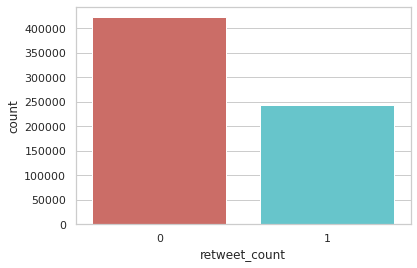

In [37]:
sns.countplot(x='retweet_count',data=train_lr,palette='hls')
plt.show()
#plt.savefig('retweetcountplot')

In [17]:
count_no_sub = len(train_lr[train_lr['retweet_count']==0])
count_sub = len(train_lr[train_lr['retweet_count']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no retweet is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of at least one retweet", pct_of_sub*100)

percentage of no retweet is 63.505197686312385
percentage of at least one retweet 36.49480231368762


In [18]:
train_lr.groupby('retweet_count').mean()

,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10,10 - 11,11 - 12,12 - 13,13 - 14,14 - 15,15 - 16,16 - 17,17 - 18,18 - 19,19 - 20,20 - 21,21 - 22,22 - 23,23 - 24
retweet_count,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.021637,32939.140042,6118.224076,1561.499812,0.00000,0.000000,0.000000,0.042736,0.040066,0.037637,0.035064,0.031071,0.027644,0.027303,0.027654,0.028744,0.029782,0.033330,0.038339,0.041875,0.045854,0.048060,0.048637,0.052485,0.051457,0.053562,0.050563,0.051137,0.049510,0.054318,0.053171
1,0.327591,56870.797143,627768.183106,4799.307728,0.35484,0.881082,0.526702,0.042017,0.041000,0.036403,0.033868,0.031682,0.031794,0.031258,0.033193,0.035292,0.032217,0.032045,0.036197,0.040037,0.045486,0.047746,0.049639,0.051137,0.051150,0.048141,0.045149,0.044832,0.042655,0.064900,0.052162


The average of `user_verified`, `user_statuses_count`, `user_followers_count`, `user_friends_count`, `user_mentions`, `urls` and `hashtags` is bigger for people who have at least one retweet in comparision to people who have 0.

### Over-Sampling using SMOTE

Let's upsample the no retweets to get a balanced dataset. We will oversample only on the training data (of course). Still not sure how smote works :(

In [19]:
X = train_lr.loc[:, train_lr.columns != 'retweet_count']
y = train_lr.loc[:, train_lr.columns == 'retweet_count']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['retweet_count'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no retweets in oversampled data",len(os_data_y[os_data_y['retweet_count']==0]))
print("Number of at least one retweet",len(os_data_y[os_data_y['retweet_count']==1]))
print("Proportion of no retweets data in oversampled data is ",len(os_data_y[os_data_y['retweet_count']==0])/len(os_data_X))
print("Proportion of at least one retweet data in oversampled data is ",len(os_data_y[os_data_y['retweet_count']==1])/len(os_data_X))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

length of oversampled data is  592002
Number of no retweets in oversampled data 296001
Number of at least one retweet 296001
Proportion of no retweets data in oversampled data is  0.5
Proportion of at least one retweet data in oversampled data is  0.5


### Recursive Feature Elimination

Our goal is to select features. Still have to understand how this method works.

In [20]:
data_final_vars=train_lr.columns.values.tolist()
y=['retweet_count']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True False  True]
[ 1  1  1  1  1  1  1  1  2  3  4  6  9 10 11 12  7  5  1  1  1  1  1  1
  1  1  1  1  1  8  1]


Let's use to train only the columns the recursive feaure elimination chose.

In [38]:
cols=['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'user_mentions', 'urls', 'hashtags', 
      '0 - 1','12 - 13', '13 - 14', '14 - 15', '15 - 16', '16 - 17', '17 - 18', 
      '18 - 19', '19 - 20', '20 - 21', '21 - 22', '22 - 23', '23 - 24']

#X=os_data_X[cols]
#y=os_data_y['retweet_count']

X = train_lr.loc[:, train_lr.columns != 'retweet_count']
y = train_lr.loc[:, train_lr.columns == 'retweet_count']


### Logistic regression model fitting

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


Let's compute : \\
precision = tp/(tp + fp) \\
recall = tp/(tp + fn) \\
F-beta score = weighted harmonic mean of the precision and recall \\
support = number of ocurrences of each class in y_test 

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79    126802
           1       0.63      0.69      0.66     72932

    accuracy                           0.74    199734
   macro avg       0.72      0.73      0.73    199734
weighted avg       0.75      0.74      0.74    199734



The accuracy without the oversampling method is better than with the oversampling.


We can also calculate the confusion matrix

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[97656 29146]
 [22491 50441]]


Finally the ROC curve

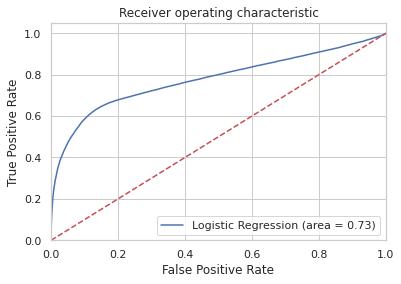

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()